CHAPTER2 Modelling random loads and stochastic waves
====================================================

Chapter2 contains the commands used in Chapter 2 of the tutorial and present some tools for analysis of random functions with respect to their correlation, spectral and distributional properties. The presentation is divided into three examples: 

Example1 is devoted to estimation of different parameters in the model.
Example2 deals with spectral densities and
Example3 presents the use of WAFO to simulate samples of a Gaussian process.

Some of the commands are edited for fast computation. 

Section 2.1 Introduction and preliminary analysis
=================================================

Example 1: Sea data
-------------------
Observed crossings compared to the expected for Gaussian signals


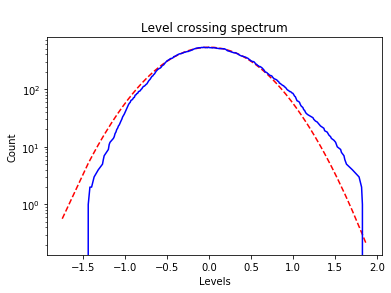

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import wafo
import wafo.objects as wo
xx = wafo.data.sea()
me = xx[:, 1].mean()
sa = xx[:, 1].std()
xx[:, 1] -= me
ts = wo.mat2timeseries(xx)
tp = ts.turning_points()

cc = tp.cycle_pairs()
lc = cc.level_crossings()
_=lc.plot()


Average number of upcrossings per time unit
----------------------------------------------
Next we compute the mean frequency as the average number of upcrossings per time unit of the mean level (= 0); this may require interpolation in the crossing intensity curve, as follows.  


In [12]:
T = xx[:, 0].max() - xx[:, 0].min()
f0 = np.interp(0, lc.args, lc.data, 0) / T  #! zero up-crossing frequency 
print('f0 = %g' % f0)

f0 = 0.224071


Turningpoints and irregularity factor
----------------------------------------

In [13]:
fm = len(tp.data) / (2 * T)   # frequency of maxima
alfa = f0 / fm                # approx Tm24/Tm02

print('fm = %g, alpha = %g, ' % (fm, alfa))

fm = 0.456159, alpha = 0.491212, 


Visually examine data
------------------------
We finish this section with some remarks about the quality of the measured data. Especially sea surface measurements can be of poor quality. We shall now check the  quality of the dataset {\tt xx}. It is always good practice to visually examine the data before the analysis to get an impression of the quality, 
non-linearities and narrow-bandedness of the data.First we shall plot the data and zoom in on a specific region. A part of sea data is visualized with the following commands

[0, 2, -2, 2]

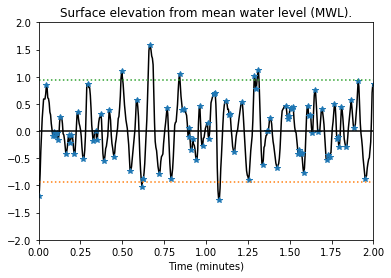

In [14]:
ts.plot_wave('k-', tp, '*', nfig=1, nsub=1)

plt.axis([0, 2, -2, 2])


Finding possible spurious points
------------------------------------
However, if the amount of data is too large for visual examinations one could use the following criteria to find possible spurious points. One must be careful using the criteria for extremevalue analysis, because
it might remove extreme waves that are OK and not spurious.

In [19]:
import wafo.misc as wm
dt = ts.sampling_period()
# dt = np.diff(xx[:2,0])
dcrit = 5 * dt
ddcrit = 9.81 / 2 * dt * dt
zcrit = 0
inds, indg = wm.findoutliers(ts.data, zcrit, dcrit, ddcrit, verbose=True)

Found 0 missing points
Found 0 spurious positive jumps of Dx
Found 0 spurious negative jumps of Dx
Found 37 spurious positive jumps of D^2x
Found 200 spurious negative jumps of D^2x
Found 244 consecutive equal values
Found the total of 1149 spurious points


Section 2.2 Frequency Modeling of Load Histories
---------------------------------------------------
Periodogram: Raw spectrum

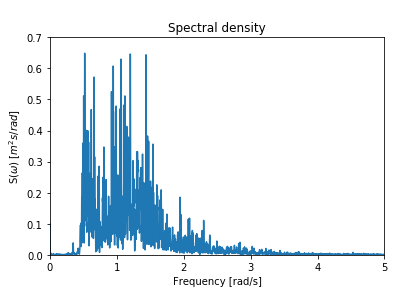

In [20]:
Lmax = 9500
S = ts.tospecdata(L=Lmax)
S.plot()
_=plt.axis([0, 5, 0, 0.7])

Calculate moments  
-------------------

In [22]:
mom, text = S.moment(nr=4)
print('sigma = %g, m0 = %g' % (sa, np.sqrt(mom[0])))

sigma = 0.472955, m0 = 0.472955


Section 2.2.1 Random functions in Spectral Domain - Gaussian processes
--------------------------------------------------------------------------
Smoothing of spectral estimate 
----------------------------------
By decreasing Lmax the spectrum estimate becomes smoother.

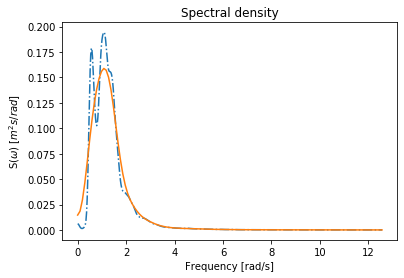

In [25]:
Lmax0 = 200; Lmax1 = 50
S1 = ts.tospecdata(L=Lmax0)
S2 = ts.tospecdata(L=Lmax1)
S1.plot('-.')
_=S2.plot()


 Estimated autocovariance
----------------------------
Obviously knowing the spectrum one can compute the covariance
function. The following code will compute the covariance for the 
unimodal spectral density S1 and compare it with estimated 
covariance of the signal xx.

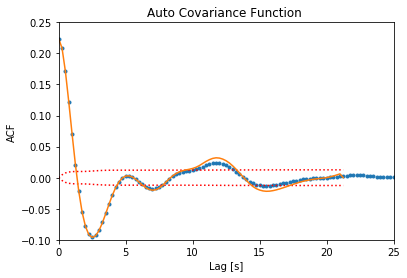

In [26]:
Lmax = 85
R1 = S1.tocovdata(nr=1)   
Rest = ts.tocovdata(lag=Lmax)
R1.plot('.')
Rest.plot()
_=plt.axis([0, 25, -0.1, 0.25])


We can see in Figure below that the covariance function corresponding to the spectral density S2 significantly differs from the one estimated directly from data. It can be seen in Figure above that the covariance corresponding to S1 agrees much better with the estimated covariance function.

(([<matplotlib.lines.Line2D at 0x2585dab92c8>],
  [Text(0.5, 1.0, 'Auto Covariance Function '),
   Text(0.5, 0, 'Lag [s]'),
   Text(0, 0.5, 'ACF')]),
 [(([<matplotlib.lines.Line2D at 0x2585dc61588>], []), None),
  (([<matplotlib.lines.Line2D at 0x2585dc76b48>], []), None)])

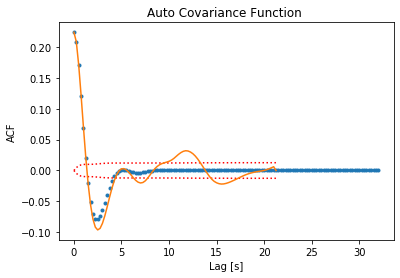

In [27]:
R2 = S2.tocovdata(nr=1)
R2.plot('.')
Rest.plot()

Section 2.2.2 Transformed Gaussian models
-------------------------------------------
We begin with computing skewness and kurtosis for the data set xx and compare it with the second order wave approximation proposed by Winterstein:

In [28]:
import wafo.stats as ws
rho3 = ws.skew(xx[:, 1])
rho4 = ws.kurtosis(xx[:, 1])

sk, ku = S1.stats_nl(moments='sk')

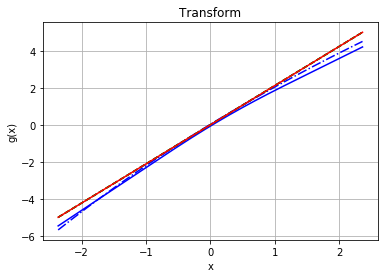

In [29]:
import wafo.transform.models as wtm
gh = wtm.TrHermite(mean=me, sigma=sa, skew=sk, kurt=ku).trdata()
g = wtm.TrLinear(mean=me, sigma=sa).trdata() # Linear transformation 
glc, gemp = lc.trdata(mean=me, sigma=sa)

glc.plot('b-') #! Transf. estimated from level-crossings
gh.plot('b-.') #! Hermite Transf. estimated from moments
g.plot('r')
plt.grid('on')


Test Gaussianity of a stochastic process
------------------------------------------
TESTGAUSSIAN simulates  e(g(u)-u) = int (g(u)-u)^2 du  for Gaussian processes given the spectral density, S. The result is plotted if test0 is given. This is useful for testing if the process X(t) is Gaussian.
If 95% of TEST1 is less than TEST0 then X(t) is not Gaussian at a 5% level.

As we see from the figure below: none of the simulated values of test1 is above 1.00. Thus the data significantly departs from a Gaussian distribution. 

False


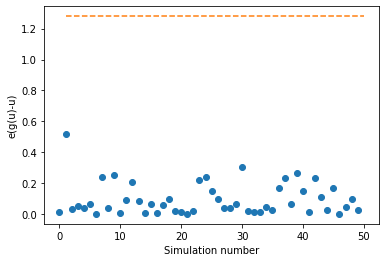

In [30]:
test0 = glc.dist2gauss()
# the following test takes time
N = len(xx)
test1 = S1.testgaussian(ns=N, cases=50, test0=test0)
is_gaussian = sum(test1 > test0) > 5 
print(is_gaussian)


Normalplot of data xx
------------------------
indicates that the underlying distribution has a "heavy" upper tail and a "light" lower tail.

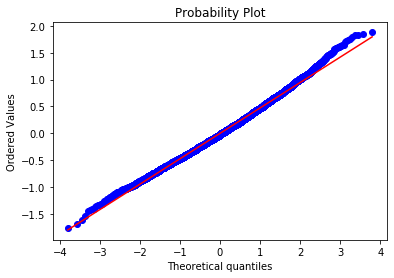

In [32]:
_=ws.probplot(ts.data.ravel(), dist='norm', plot=plt)

Section 2.2.3 Spectral densities of sea data
-----------------------------------------------
Example 2: Different forms of spectra

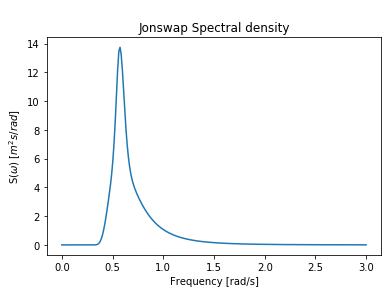

In [35]:
import wafo.spectrum.models as wsm
Hm0 = 7; Tp = 11;
spec = wsm.Jonswap(Hm0=Hm0, Tp=Tp).tospecdata()
_=spec.plot()


Directional spectrum and Encountered directional spectrum
=========================================================
Directional spectrum
---------------------

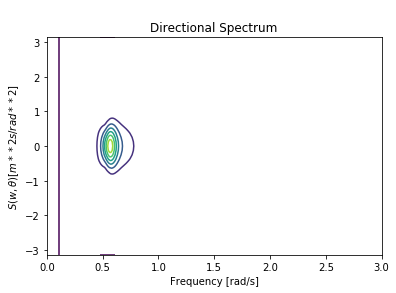

In [37]:
D = wsm.Spreading('cos2s')
Sd = D.tospecdata2d(spec)
_=Sd.plot()

Encountered directional spectrum
--------------------------------- 

In [38]:
#clf()
#Se = spec2spec(Sd,'encdir',0,10);
#plotspec(Se), hold on
#plotspec(Sd,1,'--'), hold off
##!wafostamp('','(ER)')
#disp('Block = 17'),pause(pstate)
#
##!#! Frequency spectra
#clf
#Sd1 =spec2spec(Sd,'freq');
#Sd2 = spec2spec(Se,'enc');
#plotspec(spec), hold on
#plotspec(Sd1,1,'.'),
#plotspec(Sd2),
##!wafostamp('','(ER)')
#hold off
#disp('Block = 18'),pause(pstate)
#
##!#! Wave number spectrum
#clf
#Sk = spec2spec(spec,'k1d')
#Skd = spec2spec(Sd,'k1d')
#plotspec(Sk), hold on
#plotspec(Skd,1,'--'), hold off
##!wafostamp('','(ER)')
#disp('Block = 19'),pause(pstate)
#
##!#! Effect of waterdepth on spectrum
#clf
#plotspec(spec,1,'--'), hold on
#S20 = spec;
#S20.S = S20.S.*phi1(S20.w,20);
#S20.h = 20;
#plotspec(S20),  hold off
##!wafostamp('','(ER)')
#disp('Block = 20'),pause(pstate)
#
##!#! Section 2.3 Simulation of transformed Gaussian process
##!#! Example 3: Simulation of random sea    
##! The reconstruct function replaces the spurious points of seasurface by
##! simulated data on the basis of the remaining data and a transformed Gaussian
##! process. As noted previously one must be careful using the criteria 
##! for finding spurious points when reconstructing a dataset, because
##! these criteria might remove the highest and steepest waves as we can see
##! in this plot where the spurious points is indicated with a '+' sign:
##!
#clf
#[y, grec] = reconstruct(xx,inds);
#waveplot(y,'-',xx(inds,:),'+',1,1)
#axis([0 inf -inf inf])
##!wafostamp('','(ER)')
#disp('Block = 21'),pause(pstate)
#
##! Compare transformation (grec) from reconstructed (y) 
##! with original (glc) from (xx)
#clf
#trplot(g), hold on
#plot(gemp(:,1),gemp(:,2))
#plot(glc(:,1),glc(:,2),'-.')
#plot(grec(:,1),grec(:,2)), hold off 
#disp('Block = 22'),pause(pstate)
#
##!#!
#clf
#L = 200;
#x = dat2gaus(y,grec);
#Sx = dat2spec(x,L);
#disp('Block = 23'),pause(pstate)
#      
##!#!
#clf
#dt = spec2dt(Sx)
#Ny = fix(2*60/dt) #! = 2 minutes
#Sx.tr = grec;
#ysim = spec2sdat(Sx,Ny);
#waveplot(ysim,'-')
##!wafostamp('','(CR)')
#disp('Block = 24'),pause(pstate)



Estimated spectrum compared to Torsethaugen spectrum
-------------------------------------------------------

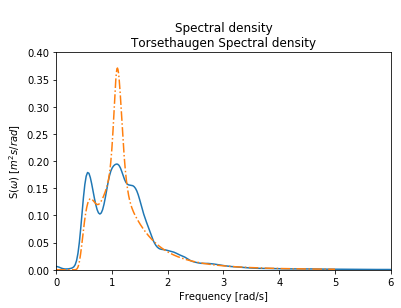

In [40]:
fp = 1.1;dw = 0.01
H0 = S1.characteristic('Hm0')[0]
St = wsm.Torsethaugen(Hm0=H0,Tp=2*np.pi/fp).tospecdata(np.arange(0,5+dw/2,dw))  
S1.plot()
St.plot('-.')
_=plt.axis([0, 6, 0, 0.4])


Transformed Gaussian model compared to Gaussian model
-------------------------------------------------------


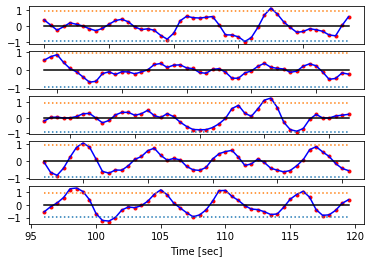

In [42]:
dt = St.sampling_period()
va, sk, ku = St.stats_nl(moments='vsk' )
#sa = sqrt(va)
gh = wtm.TrHermite(mean=me, sigma=sa, skew=sk, kurt=ku, ysigma=sa)
 
ysim_t = St.sim(ns=240, dt=0.5)
xsim_t = ysim_t.copy()
xsim_t[:,1] = gh.gauss2dat(ysim_t[:,1])

ts_y = wo.mat2timeseries(ysim_t)
ts_x = wo.mat2timeseries(xsim_t)
_=ts_y.plot_wave(sym1='r.', ts=ts_x, sym2='b', sigma=sa, nsub=5, nfig=1)
